1. **Datenvorbereitung**:

 - Lade den Wetterdatensatz "dirty_data.csv" und wandle die date-Spalte in das DateTime-Format um.
 - Setze die date-Spalte als Index.

In [128]:
import pandas as pd
import numpy as np

file_path = 'dirty_data.csv'
df = pd.read_csv(file_path)

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,station,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESF,inclement_weather
date,,,,,,,,,
2018-01-01,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
2018-01-01,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
2018-01-01,?,0.0,0.0,-inf,5505.0,-40.0,NaN,NaN,NaN
2018-01-02,GHCND:USC00280907,0.0,0.0,-inf,-8.3,-16.1,-12.2,NaN,False
2018-01-03,GHCND:USC00280907,0.0,0.0,-inf,-4.4,-13.9,-13.3,NaN,False


2. **Bereinigung der Temperaturwerte**:

 - Identifiziere offensichtliche Fehler in den Temperaturwerten (TMAX, TMIN) und ersetze diese durch NaN oder einen anderen, passenden Wert.
 - Ersetze fehlende Werte in den Temperaturspalten (TMAX, TMIN, TOBS) durch einen passenden Wert (z.B. Mittelwert der +-4 Tage zuvor/danach)

In [122]:
min_temp, max_temp = -30, 50

df[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS', 'WESF']] = df[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS', 'WESF']].apply(pd.to_numeric, errors='coerce')
df['TMAX'] = df['TMAX'].apply(lambda x: np.nan if x < min_temp or x > max_temp else x)
df['TMIN'] = df['TMIN'].apply(lambda x: np.nan if x < min_temp or x > max_temp else x)

print(df[['TMAX', 'TMIN']].isna().sum())
print()

for column in ['TMAX', 'TMIN', 'TOBS']:
    df[column] = df[column].fillna(df[column].rolling(window=9, min_periods=1, center=True).mean())

print(df[['TMAX', 'TMIN', 'TOBS']].isna().sum())

df.fillna({'SNOW' : 0}, inplace=True)
df.replace({'station': {"?": "Unknown"}}, inplace=True)
df = df[~df.index.duplicated(keep='first')]
display(df)

df.to_csv('cleaned_data.csv')

TMAX    367
TMIN    367
dtype: int64

TMAX    8
TMIN    8
TOBS    8
dtype: int64


,station,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESF,inclement_weather
date,,,,,,,,,
2018-01-01,Unknown,0.0,0.0,-inf,-6.350000,-15.000000,-12.750,NaN,NaN
2018-01-02,GHCND:USC00280907,0.0,0.0,-inf,-8.300000,-16.100000,-12.200,NaN,False
2018-01-03,GHCND:USC00280907,0.0,0.0,-inf,-4.400000,-13.900000,-13.300,NaN,False
2018-01-04,Unknown,20.6,229.0,inf,-5.180000,-14.340000,-13.200,19.3,True
2018-01-05,Unknown,0.3,0.0,NaN,-6.980000,-14.900000,-14.320,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2018-12-27,GHCND:USC00280907,0.0,0.0,-inf,5.600000,-2.200000,-1.100,NaN,False
2018-12-28,Unknown,11.4,0.0,NaN,5.725000,-2.075000,0.425,NaN,NaN
2018-12-29,Unknown,21.3,0.0,NaN,4.233333,-2.766667,-0.200,NaN,NaN


3. **Monatliche Temperaturdifferenz**:

 - Erstelle eine neue Spalte Temp_Difference, die die Differenz zwischen TMAX und TMIN darstellt.
 - Berechne den durchschnittlichen Temperaturunterschied für jeden Monat und visualisiere die Ergebnisse in einem Balkendiagramm.

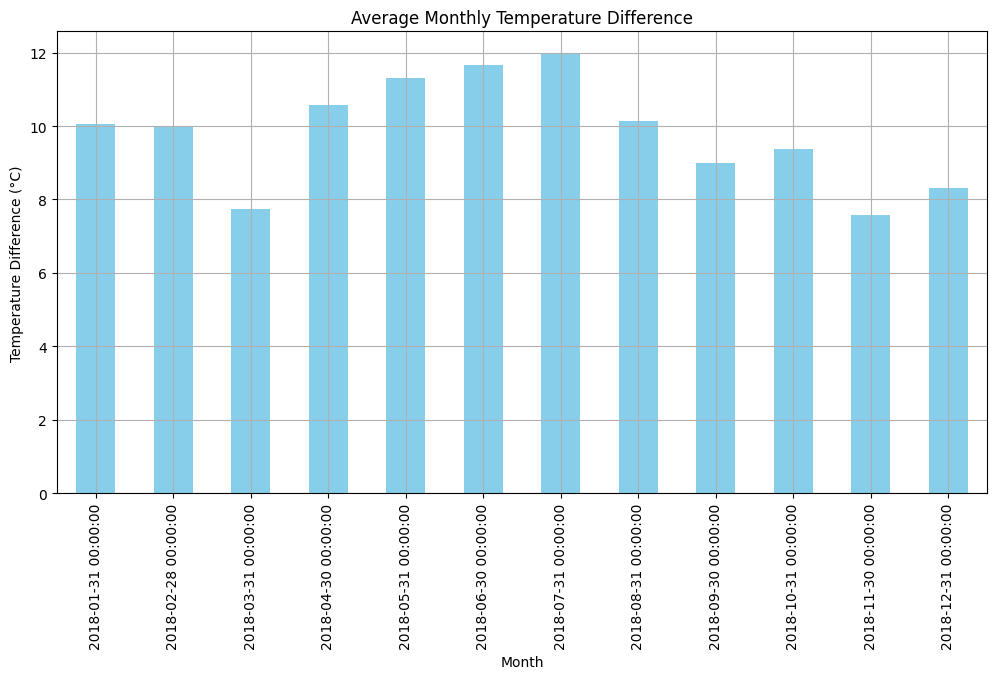

In [123]:
import matplotlib.pyplot as plt

df['Temp_Difference'] = df['TMAX'] - df['TMIN']
monthly_temp_diff = df['Temp_Difference'].resample('ME').mean()

plt.figure(figsize=(12, 6))
monthly_temp_diff.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Temperature Difference')
plt.xlabel('Month')
plt.ylabel('Temperature Difference (°C)')
plt.grid(True)
plt.show()

4. **Höchste und niedrigste Temperaturen**:

 - Bestimme den Tag mit der höchsten und niedrigsten Temperatur (TMAX und TMIN) im Jahr 2018.
 - Visualisiere die täglichen Maximal- und Minimaltemperaturen für das Jahr 2018 in einem Liniendiagramm.

Day with highest temperature in 2018: 2018-07-03 00:00:00 with 35.0°C

Day with lowest temperature in 2018: 2018-01-07 00:00:00 with -17.2°C


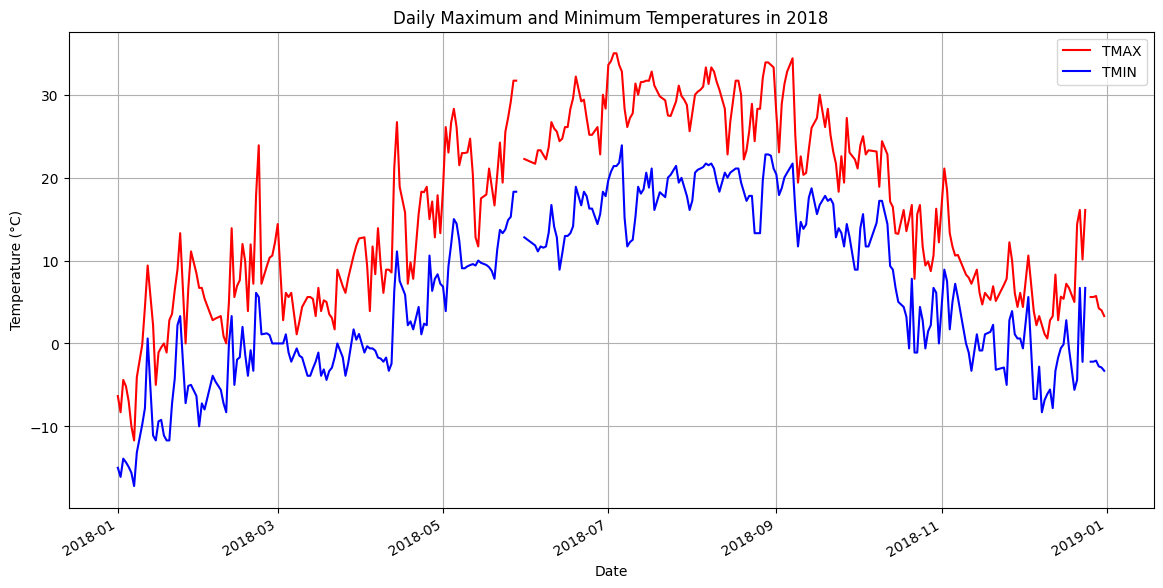

In [124]:
df_2018 = df.loc['2018']
highest_temp_day = df_2018['TMAX'].idxmax()
lowest_temp_day = df_2018['TMIN'].idxmin()

print(f"Day with highest temperature in 2018: {highest_temp_day} with {df_2018.loc[highest_temp_day, 'TMAX']}°C")
print()
print(f"Day with lowest temperature in 2018: {lowest_temp_day} with {df_2018.loc[lowest_temp_day, 'TMIN']}°C")

plt.figure(figsize=(14, 7))
df_2018['TMAX'].plot(label='TMAX', color='r')
df_2018['TMIN'].plot(label='TMIN', color='b')
plt.title('Daily Maximum and Minimum Temperatures in 2018')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

5. **Monatlicher Gesamtniederschlag**:

 - Berechne den monatlichen Gesamtniederschlag (PRCP) für das Jahr 2018.
 - Visualisiere den monatlichen Gesamtniederschlag in einem Liniendiagramm.

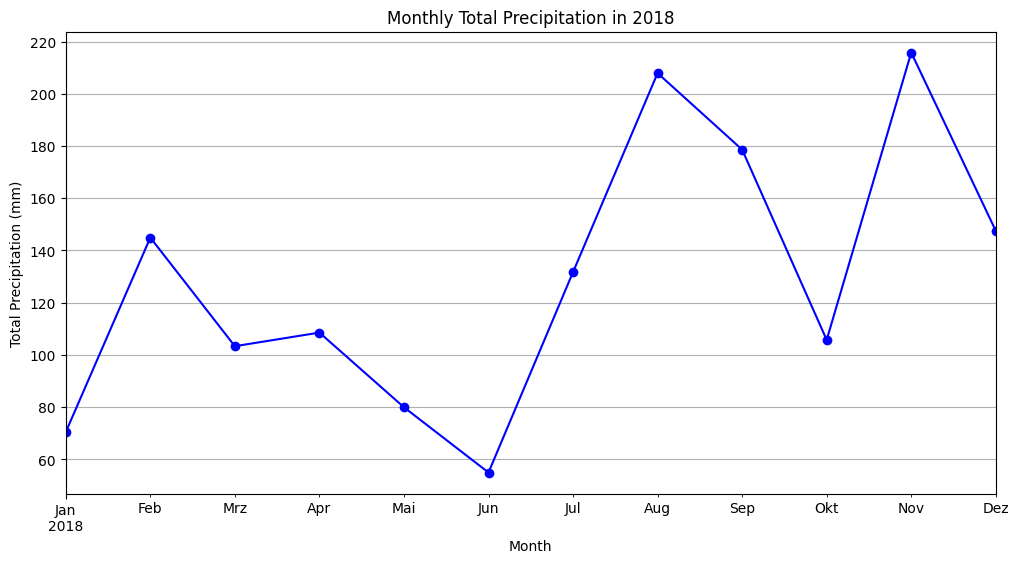

In [125]:
monthly_prcp_2018 = df.loc['2018', 'PRCP'].resample('ME').sum()

plt.figure(figsize=(12, 6))
monthly_prcp_2018.plot(kind='line', color='blue', marker='o')
plt.title('Monthly Total Precipitation in 2018')
plt.xlabel('Month')
plt.ylabel('Total Precipitation (mm)')
plt.grid(True)
plt.show()

6. **Tage ohne Niederschlag**:

 - Bestimme die Anzahl der Tage ohne Niederschlag (PRCP = 0) für jedes Jahr im Datensatz.
 - Visualisiere die Anzahl der Tage ohne Niederschlag pro Jahr in einem Balkendiagramm.

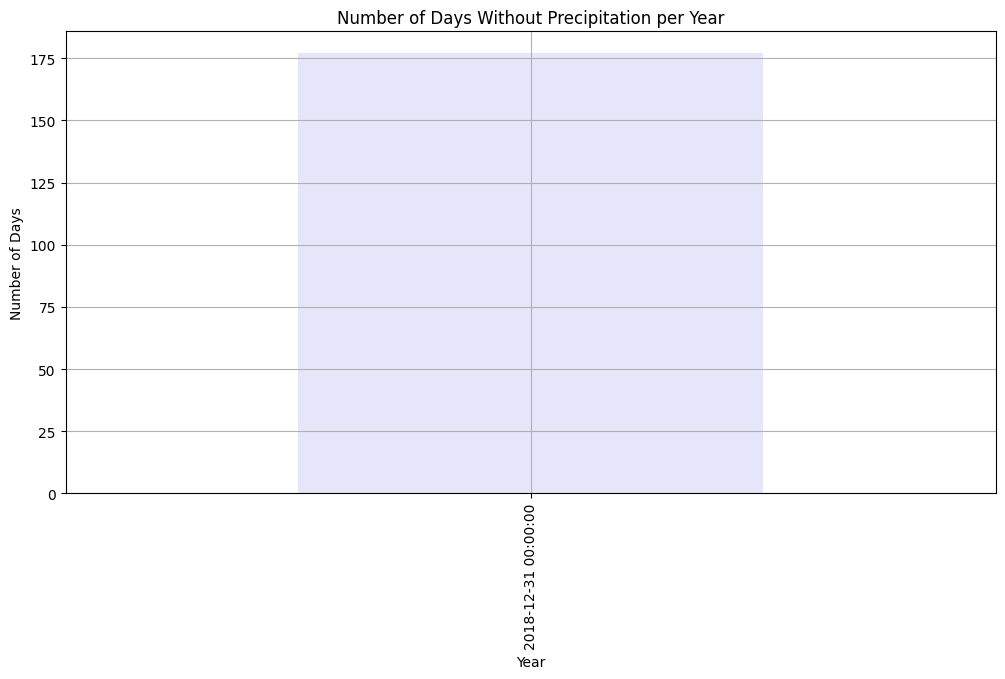

In [126]:
days_without_prcp = df[df['PRCP'] == 0].resample('YE').size()

plt.figure(figsize=(12, 6))
days_without_prcp.plot(kind='bar', color='lavender')
plt.title('Number of Days Without Precipitation per Year')
plt.xlabel('Year')
plt.ylabel('Number of Days')
plt.grid(True)
plt.show()

7. **Winteranalyse**:
 - Berechne die Gesamtschneefälle (SNOW) für den Winter Anfang 2018 und Ende 2018 (Dezember bis Februar).
 - Bestimme die maximale Schneehöhe (SNWD) und den entsprechenden Tag.

Total snowfall for Winter early 2018: 458.0 mm
Total snowfall for Winter late 2018: 0.0 mm

Maximum snow depth of inf mm on 2018-01-04 00:00:00


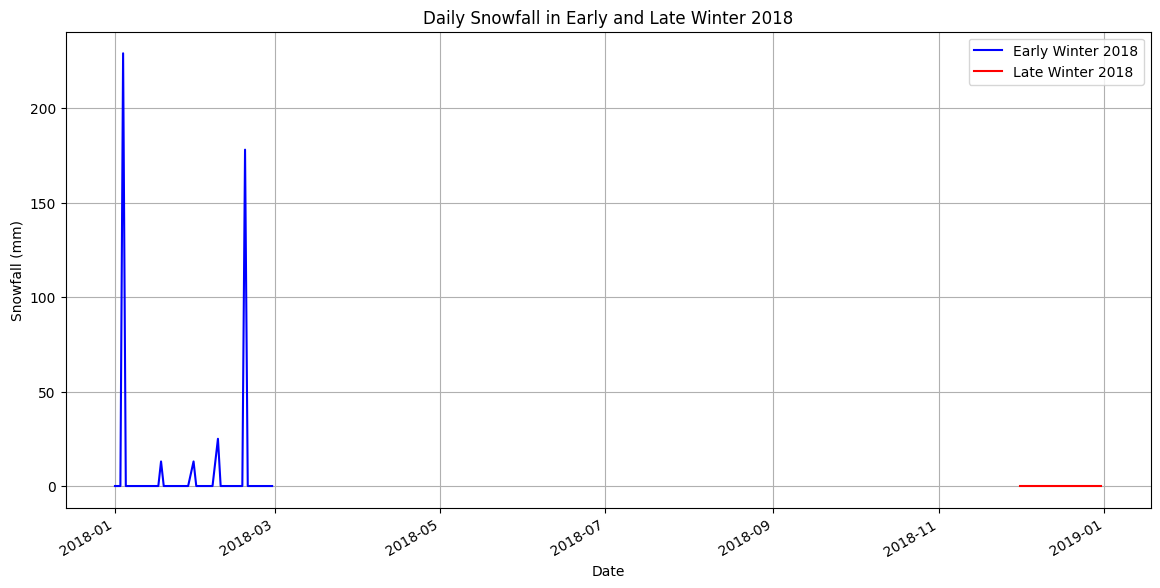

In [127]:
winter_early_2018 = df.loc['2017-12':'2018-02', 'SNOW'].sum()
winter_late_2018 = df.loc['2018-12':'2019-02', 'SNOW'].sum()

print(f"Total snowfall for Winter early 2018: {winter_early_2018} mm")
print(f"Total snowfall for Winter late 2018: {winter_late_2018} mm")
print()

max_snow_depth = df['SNWD'].idxmax()
max_snow_depth_value = df.loc[max_snow_depth, 'SNWD']

print(f"Maximum snow depth of {max_snow_depth_value} mm on {max_snow_depth}")

plt.figure(figsize=(14, 7))
df.loc['2017-12':'2018-02', 'SNOW'].plot(label='Early Winter 2018', color='blue')
df.loc['2018-12':'2019-02', 'SNOW'].plot(label='Late Winter 2018', color='red')
plt.title('Daily Snowfall in Early and Late Winter 2018')
plt.xlabel('Date')
plt.ylabel('Snowfall (mm)')
plt.legend()
plt.grid(True)
plt.show()
